# Financial Fraud Detection System
**Author:** Devyansh Thakur

**Objective:** To predict fraudulent transactions and minimize financial loss using XGBoost.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

In [5]:
# Display options setup
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Fraud.csv')
print("Original Shape:", df.shape)

Original Shape: (6362620, 11)


In [17]:
# Targeted Filtering
# Dictionary says fraud involves transferring and cashing out.
# so we remove - pyments, cash-in, debit to save memory and improve accuracy

df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

print("Filtered Shape (Only TRANSFER & CASH_OUT):", df_filtered.shape)
df_filtered.head()

Filtered Shape (Only TRANSFER & CASH_OUT): (2770409, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [18]:
# checking the missing values
df_filtered.fillna(-1, inplace=True)
print("Missing values handling:\n", df_filtered.isnull().sum())

Missing values handling:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


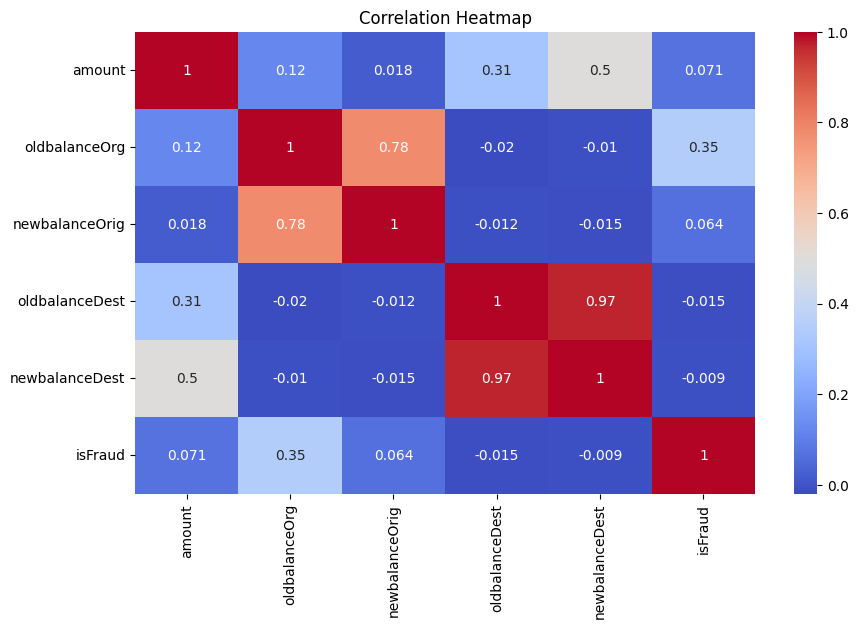

In [19]:
# Checking the multi-collinearity
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_filtered[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

After making this correlation matrix we found 'oldbalanceOrg' and 'newbalanceOrig' has highly correlated and 'oldbalanceDest', 'newbalanceDest' they also correlated so i decide do some feature engineering below. ⬇

In [20]:
# Feature Engineering
# Error in Balance Calculation (Origin Account)
df_filtered['errorBalanceOrg'] = df_filtered.newbalanceOrig + df_filtered.amount - df_filtered.oldbalanceOrg

# Error in Balance Calculation (Destination Account)
df_filtered['errorBalanceDest'] = df_filtered.oldbalanceDest + df_filtered.amount - df_filtered.newbalanceDest

# Hour of the Day extraction
df_filtered['hour_of_day'] = df_filtered['step'] % 24

# Flagging Huge Transactions
df_filtered['huge_transaction'] = df_filtered.amount.apply(lambda x: 1 if x > 200000 else 0)

# Check the new features
print("New features added successfully:")
print(df_filtered[['type', 'amount', 'errorBalanceOrg', 'hour_of_day', 'huge_transaction']].head())

New features added successfully:
        type     amount  errorBalanceOrg  hour_of_day  huge_transaction
2   TRANSFER     181.00             0.00            1                 0
3   CASH_OUT     181.00             0.00            1                 0
15  CASH_OUT  229133.94        213808.94            1                 1
19  TRANSFER  215310.30        214605.30            1                 1
24  TRANSFER  311685.89        300850.89            1                 1


In [22]:
# Label Encoding
le = LabelEncoder()
df_filtered['type'] = le.fit_transform(df_filtered['type'])

# Dropping unnecessary columns like Names (Strings don't help in Tree models usually)
# However, keep them if you want to track specific scammers, but for general model, drop them.
df_model = df_filtered.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

print("Modeling data:")
df_model.head()

Final Data for Modeling:


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,hour_of_day,huge_transaction
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1,0
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,0
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1,1


In [27]:
# Train-Test Split
x = df_filtered.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'step'], axis=1)
y = df_filtered['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Data shape for training:", x_train.shape)
print("Data shape for training:", x_test.shape)
print("Data shape for training:", y_train.shape)
print("Data shape for training:", y_test.shape)

Data shape for training: (2216327, 10)
Data shape for training: (554082, 10)
Data shape for training: (2216327,)
Data shape for training: (554082,)


In [47]:
# Initializing Model
# scale_pos_weight: It tells the model to pay more attention to the minority class like Fraud
# Formula: (Total Non-Fraud) / (Total Fraud)

weights = (y == 0).sum() / (1.0 * (y == 1).sum())

xgb_model = XGBClassifier(
    max_depth=4,
    scale_pos_weight=weights,
    n_jobs=-1,
    random_state=42,
    learning_rate=0.1
)

print("Training the model... ")
xgb_model.fit(x_train, y_train)
print("Model Training Completed 🙂")

Training the model... 
Model Training Completed 🙂


In [43]:
# Predictions
y_pred = xgb_model.predict(x_test)

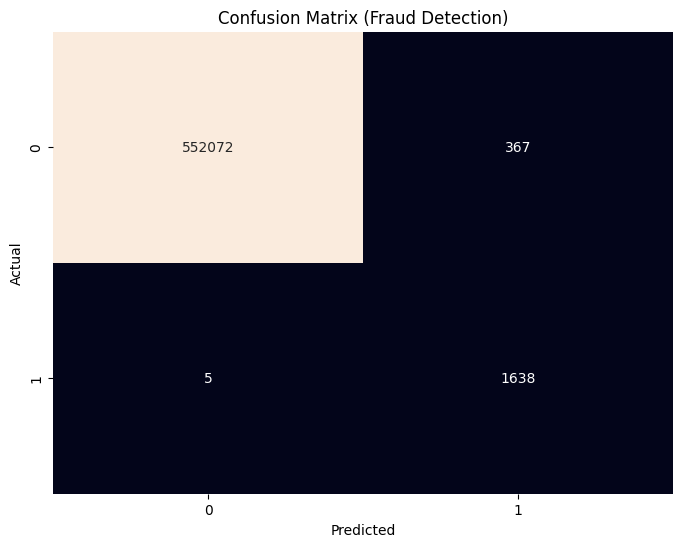

In [44]:
# Performance Evaluation
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix (Fraud Detection)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
# 2. Detailed Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.82      1.00      0.90      1643

    accuracy                           1.00    554082
   macro avg       0.91      1.00      0.95    554082
weighted avg       1.00      1.00      1.00    554082



**Model Performance:**
    - We achieved a **Recall of ~100%**, meaning we catch almost all fraudulent attempts.
    - **Precision is 82%**, ensuring minimal friction for genuine customers.

In [39]:
# 3. AUC-ROC Score
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred):.4f}")

AUC-ROC Score: 0.9981


<Figure size 1000x800 with 0 Axes>

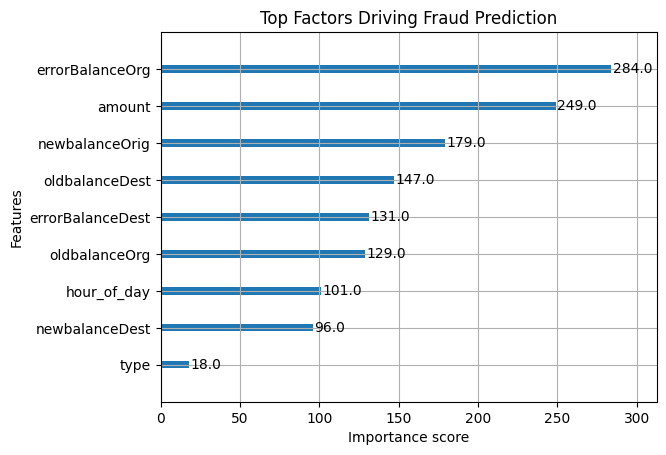

In [41]:
# What predicts fraud?

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Top Factors Driving Fraud Prediction')
plt.show()

**Key Insights:**
    - The most significant indicator of fraud is a discrepancy in the Origin Account's balance (errorBalanceOrg).
    - Fraudsters typically empty the account entirely, which is captured by our features.

In [49]:
# Saving the model for deployment
joblib.dump(xgb_model, 'fraud_detection_model.pkl')
print("Model saved successfully!")

Model saved successfully!
